### Deep CNN-Based CAD System for COVID-19 Detection.
#### _ Mehrad Aria

In [1]:
import os
import random
import numpy as np
import math
import itertools

SEED = 7
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

from tensorflow.keras.applications import NASNetLarge
NETWORK = NASNetLarge

from kaggle_datasets import KaggleDatasets

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report


import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print("Tensorflow version ", tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
Tensorflow version  2.4.1


In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

In [4]:
# Cosine annealing scheduler
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

dataset_id1 = 'covid19-lung-ct-scans'
GCS_PATH1 = KaggleDatasets().get_gcs_path(dataset_id1)
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

CLASSES = ['COVID-19', 'Non-COVID-19']
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = [224, 224]
input_shape = (224, 224, 3)
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

METRICS = ['accuracy']

Epochs = 50
Early_Stop = 15
OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-2, decay = 1e-5)

Fine_Tune_Epochs = 100
Fine_Tune_Early_Stop = 20
Fine_Tune_OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-3, decay = 1e-6)
Fine_Tune_filepath = "Best-Model-FT.h5"

Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

FT_Callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min', min_delta=0.0001, cooldown=1, min_lr=1e-6),
    ModelCheckpoint(Fine_Tune_filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor='val_loss', patience=Fine_Tune_Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

In [6]:
filenames = tf.io.gfile.glob(str(GCS_PATH1 + '/COVID-19_Lung_CT_Scans/COVID-19/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH1 + '/COVID-19_Lung_CT_Scans/Non-COVID-19/*')))

filenames.remove(str(GCS_PATH1 + '/COVID-19_Lung_CT_Scans/COVID-19/desktop.ini'))
    
random.shuffle(filenames)

In [7]:
COUNT_COVID = len([filename for filename in filenames if "/COVID-19/" in filename])
print("COVID-19 images count : " + str(COUNT_COVID))

COUNT_Non_COVID = len([filename for filename in filenames if "/Non-COVID-19/" in filename])
print("Non-COVID images count : " + str(COUNT_Non_COVID))

COVID-19 images count : 7495
Non-COVID images count : 944


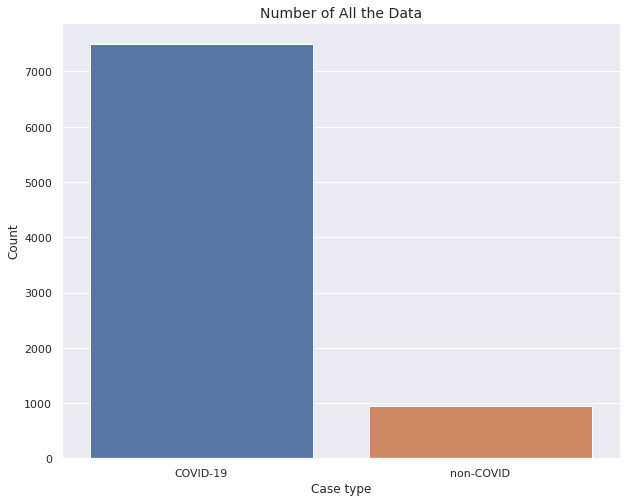

       Cases  Cases_count
0   COVID-19         7495
1  non-COVID          944


In [8]:
data = {'Cases':['COVID-19', 'non-COVID'],
        'Cases_count':[COUNT_COVID, COUNT_Non_COVID]
       }

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x=df.index, y= df['Cases_count'].values)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(df.index)), ['COVID-19', 'non-COVID'])
plt.show()

print(df)

In [9]:
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Test_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Testing images count: " + str(Test_IMG_COUNT))

Training images count: 5400
Validating images count: 1351
Testing images count: 1688


In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return int(parts[-2] == CLASSES)

In [13]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
def prepare_for_training(ds, cache=True):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)

    if cache:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [17]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_training(test_ds, False)

In [18]:
img_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomContrast(factor=0.20)
    ],name="Augmentation")

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASSES[np.argmax(label_batch[n])])
        plt.axis("off")

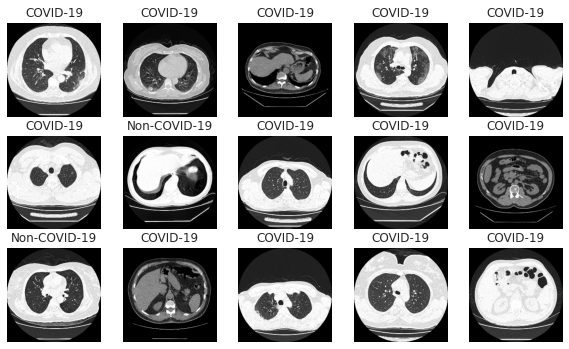

In [20]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [21]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    return numpy_images, numpy_labels

x_test, y_test = dataset_to_numpy_util(test_ds, Test_IMG_COUNT)

print("Evaluation Dataset:")
print('X shape: ', x_test.shape,' Y shape: ', y_test.shape)

Evaluation Dataset:
X shape:  (1688, 224, 224, 3)  Y shape:  (1688, 2)


In [22]:
def weight_classes(extra_weight=False, ew_value=1):
    total_COUNT = COUNT_COVID + COUNT_Non_COVID

    weight_for_0 = (1 / COUNT_COVID) * total_COUNT / 2.0 
    weight_for_1 = (1 / COUNT_Non_COVID) * total_COUNT / 2.0
    
    if extra_weight:
        weight_for_1 *= ew_value

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print(f'Weight for class 0: {weight_for_0}')
    print(f'Weight for class 1: {weight_for_1}')
    
    return class_weight

In [23]:
class_weight = weight_classes(extra_weight=False, ew_value=1.5)

Weight for class 0: 0.5629753168779186
Weight for class 1: 4.469809322033898


In [24]:
def build_model(OPTIMIZER, LOSS, METRICS):
    model = None
    inputs = layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    baseModel = NETWORK(include_top=False, input_tensor=x, weights="imagenet", pooling ='avg')

    baseModel.trainable = False

    x = BatchNormalization(axis = -1, name="Batch-Normalization-1")(baseModel.output)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-2")(x)
    x = Dropout(.2, name="Dropout-1")(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-3")(x)
    
    outputs = Dense(NUM_CLASSES, activation="softmax", name="Classifier")(x)
    model = tf.keras.Model(inputs=baseModel.input, outputs=outputs, name="Deep-COVID")
    
    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
        
    return model

In [1]:
with strategy.scope():
    model = build_model(OPTIMIZER, LOSS, METRICS)

In [26]:
def fit_model(Epochs, Callbacks, class_weight=None):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=Epochs,
        callbacks=Callbacks,
        verbose=2,
        class_weight=class_weight
    )
    return history
    
history = fit_model(Epochs, Callbacks, class_weight=class_weight)

Epoch 1/50
6/6 - 248s - loss: 1.1131 - accuracy: 0.6539 - val_loss: 0.7578 - val_accuracy: 0.9060
Epoch 2/50
6/6 - 142s - loss: 0.8433 - accuracy: 0.6815 - val_loss: 0.6990 - val_accuracy: 0.9060
Epoch 3/50
6/6 - 139s - loss: 0.7388 - accuracy: 0.7954 - val_loss: 0.6727 - val_accuracy: 0.9260
Epoch 4/50
6/6 - 139s - loss: 0.6777 - accuracy: 0.8693 - val_loss: 0.6468 - val_accuracy: 0.9193
Epoch 5/50
6/6 - 140s - loss: 0.6327 - accuracy: 0.9270 - val_loss: 0.6148 - val_accuracy: 0.9230
Epoch 6/50
6/6 - 141s - loss: 0.5972 - accuracy: 0.9556 - val_loss: 0.5998 - val_accuracy: 0.9304
Epoch 7/50
6/6 - 139s - loss: 0.5731 - accuracy: 0.9698 - val_loss: 0.5813 - val_accuracy: 0.9297
Epoch 8/50
6/6 - 141s - loss: 0.5504 - accuracy: 0.9865 - val_loss: 0.5708 - val_accuracy: 0.9267
Epoch 9/50
6/6 - 143s - loss: 0.5360 - accuracy: 0.9926 - val_loss: 0.5623 - val_accuracy: 0.9363
Epoch 10/50
6/6 - 142s - loss: 0.5248 - accuracy: 0.9946 - val_loss: 0.5548 - val_accuracy: 0.9334
Epoch 11/50
6/6 - 1

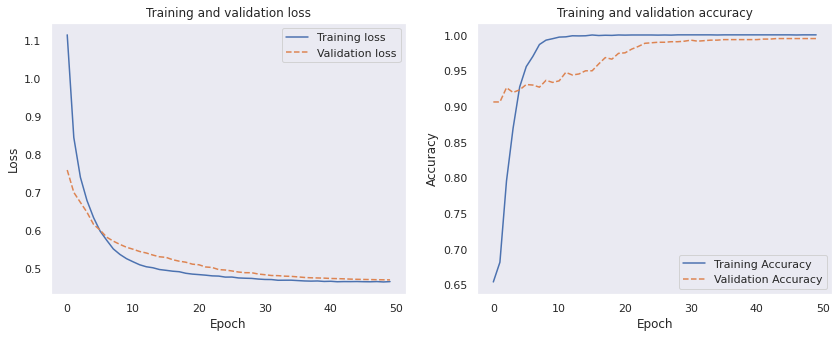

In [27]:
def Plot_Learning_Curves():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    sns.set(style="dark")
    plt.rcParams['figure.figsize'] = (14, 5)

    plt.subplot(1,2,1)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, linestyle="--", label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss') 
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, linestyle="--", label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy') 
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
    
Plot_Learning_Curves()

In [28]:
def evaluate_model(model):
    results = model.evaluate(test_ds, return_dict=True)
    print ('\nModel Evaluation:')
    print(results['accuracy']*100)
    return results
    
results = evaluate_model(model)

2/2 [==============================] - 53s 17s/step - loss: 0.4688 - accuracy: 0.9964

Model Evaluation:
99.64454174041748


In [29]:
def fine_tune(OPTIMIZER, LOSS, METRICS):
    for layer in model.layers[-54:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            
    model.compile(optimizer = Fine_Tune_OPTIMIZER, loss = LOSS, metrics = METRICS)
    return model

In [30]:
with strategy.scope():
    model = fine_tune(Fine_Tune_OPTIMIZER, LOSS, METRICS)

In [31]:
history = fit_model(Fine_Tune_Epochs, FT_Callbacks, class_weight=class_weight)

Epoch 1/100
6/6 - 224s - loss: 0.5049 - accuracy: 0.9878 - val_loss: 0.7176 - val_accuracy: 0.8971

Epoch 00001: val_accuracy improved from -inf to 0.89711, saving model to Best-Model-FT.h5
Epoch 2/100
6/6 - 142s - loss: 0.4817 - accuracy: 0.9948 - val_loss: 0.9811 - val_accuracy: 0.8897

Epoch 00002: val_accuracy did not improve from 0.89711
Epoch 3/100
6/6 - 140s - loss: 0.4789 - accuracy: 0.9922 - val_loss: 0.9142 - val_accuracy: 0.8882

Epoch 00003: val_accuracy did not improve from 0.89711
Epoch 4/100
6/6 - 143s - loss: 0.4674 - accuracy: 0.9980 - val_loss: 0.7995 - val_accuracy: 0.8756

Epoch 00004: val_accuracy did not improve from 0.89711
Epoch 5/100
6/6 - 144s - loss: 0.4634 - accuracy: 0.9996 - val_loss: 0.7242 - val_accuracy: 0.8076

Epoch 00005: val_accuracy did not improve from 0.89711
Epoch 6/100
6/6 - 140s - loss: 0.4578 - accuracy: 0.9996 - val_loss: 0.7134 - val_accuracy: 0.8616

Epoch 00006: val_accuracy did not improve from 0.89711
Epoch 7/100
6/6 - 146s - loss: 0.45

In [32]:
model = load_model(Fine_Tune_filepath)

results = model.evaluate(test_ds, return_dict=True)
print ('\nModel Evaluation:')
print(results['accuracy']*100)

2/2 [==============================] - 57s 8s/step - loss: 0.3617 - accuracy: 0.9994

Model Evaluation:
99.94075894355774


In [33]:
if not TPU_accelerator:
    tf.keras.mixed_precision.set_global_policy('float32')

Shape of preds:  (1688, 2)


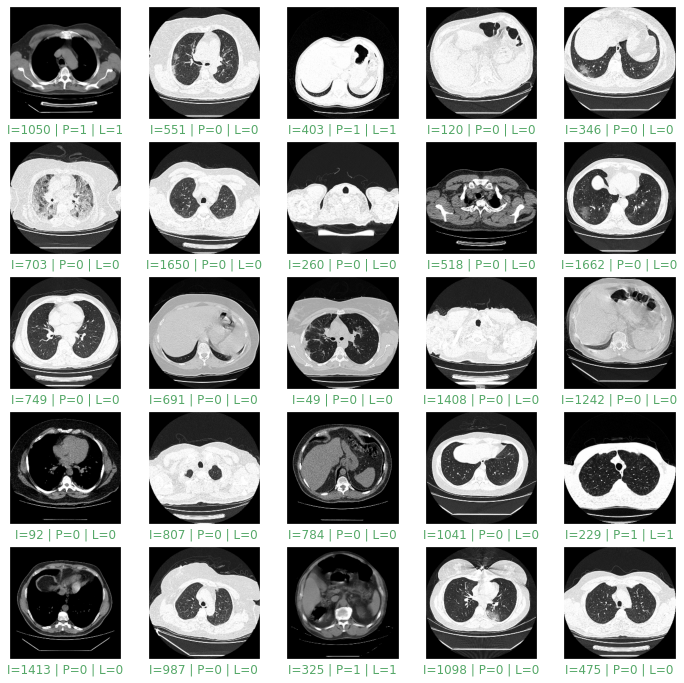

In [34]:
preds = model.predict(x_test)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

R = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    R = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[R])
    actual = np.argmax(y_test[R])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('I={} | P={} | L={}'.format(R, pred, actual), color = col)
    plt.imshow(((x_test[R]* 255).astype(np.uint8)), cmap='binary')
plt.show()

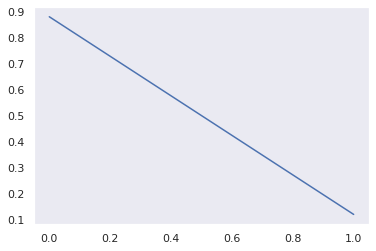

In [35]:
index = 0
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(preds[index])
sns.set(style="darkgrid")
plt.show()

In [36]:
categories = ['COVID-19', 'Non-COVID-19']
preds = np.round(preds,0)
class_metrics = metrics.classification_report(y_test, preds, target_names = categories, zero_division = 0)
print (class_metrics)

              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00      1493
Non-COVID-19       0.99      1.00      1.00       195

   micro avg       1.00      1.00      1.00      1688
   macro avg       1.00      1.00      1.00      1688
weighted avg       1.00      1.00      1.00      1688
 samples avg       1.00      1.00      1.00      1688



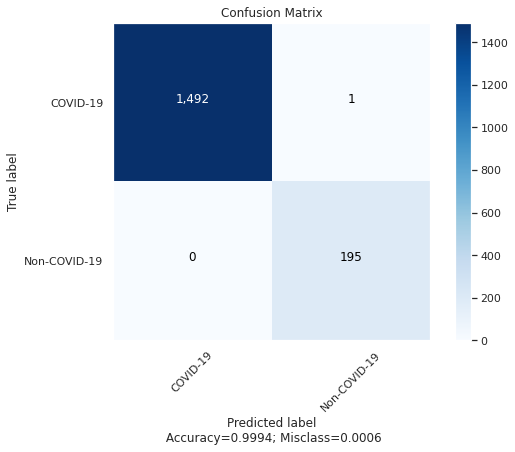

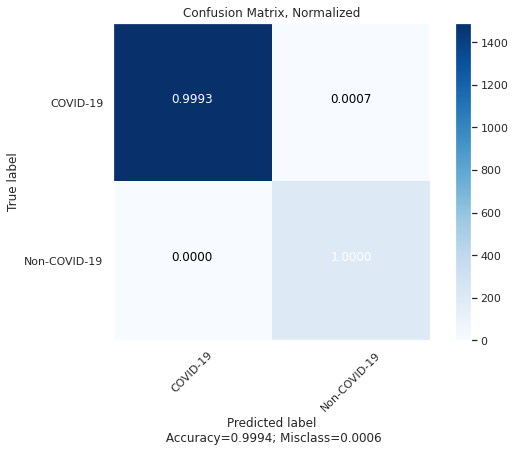

In [37]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = categories,
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = categories,
                      title        = "Confusion Matrix, Normalized")

In [38]:
test_image = x_test[0]
x = np.expand_dims(test_image, axis=0)
x = x/255

images = np.vstack([x])

classes = model.predict(images, batch_size=BATCH_SIZE)
classes = np.argmax(classes,axis=1)

print ('Class:', categories[int(classes)] )

Class: Non-COVID-19


In [39]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MSE = mean_squared_error(y_test, preds)

print('MSE:', MSE)
print('Accuracy:', ACC)
print('Precision (positive predictive value):', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate):', TNR)
print('Negative Predictive Value:', NPV)
print('Fall out (false positive rate):', FPR)
print('False Negative Rate:', FNR)
print('False discovery rate:', FDR)

Other Metrics:
MSE: 0.0005924170616113745
Accuracy: [0.99940758 0.99940758]
Precision (positive predictive value): [1.         0.99489796]
Recall (Sensitivity, hit rate, true positive rate): [0.99933021 1.        ]
Specificity (true negative rate): [1.         0.99933021]
Negative Predictive Value: [0.99489796 1.        ]
Fall out (false positive rate): [0.         0.00066979]
False Negative Rate: [0.00066979 0.        ]
False discovery rate: [0.         0.00510204]


----

**Deep-COVID** V.1.0.08 | Deep CNN-Based CAD System for COVID-19 Detection Using Multiple Lung CT Scans.
<br>{Binary (COVID-19, Non-COVID) clasification.}

© Proposed Method Implementation by **Mehrad Aria** for Paper [Deep Convolutional Neural Network–Based Computer-Aided Detection System for COVID-19 Using Multiple Lung Scans: Design and Implementation Study](https://doi.org/10.2196/27468).
<br>Jan 2021 / Shiraz, Iran.

----